In [1]:
# --- Block 1: Imports & data load (with unix time handling) ---
import pandas as pd
import numpy as np
from pathlib import Path

# Read QQQ hourly data from the same folder
csv_path = Path("qqqh1.csv")
df = pd.read_csv(csv_path)

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Handle case where file has 'time' instead of 'datetime'
if "time" in df.columns and "datetime" not in df.columns:
    df.rename(columns={"time": "datetime"}, inplace=True)

required = {"datetime","open","high","low","close"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in qqqh1.csv: {missing}")

# Parse datetime (auto-detect unix vs string)
if np.issubdtype(df["datetime"].dtype, np.number):
    # Likely UNIX time — detect if seconds or ms
    if df["datetime"].max() > 1e12:  # ms
        df["datetime"] = pd.to_datetime(df["datetime"], unit="ms")
    else:  # seconds
        df["datetime"] = pd.to_datetime(df["datetime"], unit="s")
else:
    df["datetime"] = pd.to_datetime(df["datetime"])

# Sort and convert OHLC to float
df = df.sort_values("datetime").reset_index(drop=True)
df[["open","high","low","close"]] = df[["open","high","low","close"]].astype(float)

# Calendar-day key
df["date"] = df["datetime"].dt.date

print("Loaded rows:", len(df))
print(df.head(3))



/var/folders/2n/rmtzbdn93h3f2tkgn0yypj300000gn/T/ipykernel_61404/1880118422.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["datetime"] = pd.to_datetime(df["datetime"])


Loaded rows: 20574
             datetime   open   high    low  close        date
0 2014-01-02 14:30:00  87.55  87.58  87.09  87.20  2014-01-02
1 2014-01-02 15:30:00  87.19  87.45  87.12  87.39  2014-01-02
2 2014-01-02 16:30:00  87.39  87.39  87.14  87.17  2014-01-02


In [2]:
# --- Block 2: Strategy functions ---

def compute_sma(series: pd.Series, period: int) -> pd.Series:
    if period and period > 0:
        return series.rolling(period, min_periods=period).mean()
    return pd.Series([np.nan]*len(series), index=series.index)

def first_bar_each_day(frame: pd.DataFrame) -> pd.DataFrame:
    """Return the first bar of each calendar date (already sorted)."""
    return frame.groupby("date", as_index=False).head(1).copy()

def exit_same_day(frame: pd.DataFrame, entry_idx: int, side: str, profit_target: float):
    """
    Determine exit time/price for a same-day trade.
    side in {"buy","sell"}.
    profit_target in % (e.g. 1.0 = 1%).
    """
    entry_row = frame.loc[entry_idx]
    entry_price = entry_row["close"]
    entry_date = entry_row["date"]

    # Bars of the same day
    day_df = frame.loc[frame["date"].eq(entry_date)]
    after = day_df[day_df["datetime"] > entry_row["datetime"]]

    # Profit target logic (in %)
    if profit_target and profit_target > 0:
        if side == "buy":
            tp = entry_price * (1 + profit_target / 100.0)
            hit = after[after["high"] >= tp]
            if len(hit):
                first_hit = hit.iloc[0]
                return first_hit["datetime"], float(tp)
        else:  # sell
            tp = entry_price * (1 - profit_target / 100.0)
            hit = after[after["low"] <= tp]
            if len(hit):
                first_hit = hit.iloc[0]
                return first_hit["datetime"], float(tp)

    # Fallback: exit at last close of day
    last_bar = day_df.iloc[-1]
    return last_bar["datetime"], float(last_bar["close"])

def run_strategy(
    data: pd.DataFrame,
    trade_mode: str = "both",       # "buy" | "sell" | "both"
    sma_period: int = 0,            # 0 => no SMA filter
    profit_target: float = 0.0      # % of entry price; 0 => close only at day's close
):
    frame = data.copy()
    frame["sma"] = compute_sma(frame["close"], sma_period)
    firsts = first_bar_each_day(frame)

    trades = []
    for _, row in firsts.iterrows():
        o, c = row["open"], row["close"]
        idx = row.name

        # Signal: buy if O<C, sell if O>C
        side = None
        if o < c: side = "buy"
        elif o > c: side = "sell"

        if not side:
            continue

        # SMA filter
        if sma_period and not np.isnan(row["sma"]):
            if row["close"] > row["sma"] and side != "buy":
                continue
            elif row["close"] < row["sma"] and side != "sell":
                continue
            elif row["close"] == row["sma"]:
                continue

        # Trade mode filter
        if trade_mode == "buy" and side != "buy":
            continue
        if trade_mode == "sell" and side != "sell":
            continue

        entry_time = row["datetime"]
        entry_price = row["close"]

        exit_time, exit_price = exit_same_day(frame, idx, side, profit_target)

        # PnL in index points (still absolute for now)
        pnl = (exit_price - entry_price) if side == "buy" else (entry_price - exit_price)

        trades.append({
            "side": side,
            "date": row["date"],
            "entry_time": entry_time,
            "exit_time": exit_time,
            "entry": float(entry_price),
            "exit": float(exit_price),
            "pnl": float(pnl)
        })

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        eq = pd.DataFrame({"time": [], "equity": [], "drawdown": []})
        summary = {
            "total_trades": 0,
            "buy": {}, "sell": {}, "all": {},
            "max_drawdown": 0.0
        }
        return trades_df, summary, eq

    trades_df = trades_df.sort_values("exit_time").reset_index(drop=True)
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()

    equity = trades_df[["exit_time","cum_pnl"]].rename(columns={"exit_time":"time","cum_pnl":"equity"}).copy()
    equity["peak"] = equity["equity"].cummax()
    equity["drawdown"] = equity["equity"] - equity["peak"]
    max_dd = float(equity["drawdown"].min())

    def side_stats(s: str):
        sdf = trades_df[trades_df["side"] == s]
        wins, losses = sdf[sdf["pnl"] > 0]["pnl"], sdf[sdf["pnl"] < 0]["pnl"]
        return {
            "count": len(sdf),
            "total_pnl": float(sdf["pnl"].sum()),
            "max_winner": float(wins.max()) if len(wins) else 0.0,
            "max_loser": float(losses.min()) if len(losses) else 0.0,
            "avg_winner": float(wins.mean()) if len(wins) else 0.0,
            "avg_loser": float(losses.mean()) if len(losses) else 0.0
        }

    stats_buy = side_stats("buy")
    stats_sell = side_stats("sell")
    stats_all = {
        "count": len(trades_df),
        "total_pnl": float(trades_df["pnl"].sum()),
        "max_winner": float(trades_df["pnl"].max()),
        "max_loser": float(trades_df["pnl"].min()),
        "avg_winner": float(trades_df[trades_df["pnl"] > 0]["pnl"].mean()) if (trades_df["pnl"] > 0).any() else 0.0,
        "avg_loser": float(trades_df[trades_df["pnl"] < 0]["pnl"].mean()) if (trades_df["pnl"] < 0).any() else 0.0,
    }

    summary = {
        "total_trades": len(trades_df),
        "buy": stats_buy,
        "sell": stats_sell,
        "all": stats_all,
        "max_drawdown": float(max_dd)
    }
    return trades_df, summary, equity[["time","equity","drawdown"]]



--- Trades ---
side       date          entry_time           exit_time   entry      exit       pnl
sell 2014-01-02 2014-01-02 14:30:00 2014-01-02 20:30:00  87.200  87.28000  -0.08000
sell 2014-01-03 2014-01-03 14:30:00 2014-01-03 20:30:00  87.140  86.63000   0.51000
sell 2014-01-06 2014-01-06 14:30:00 2014-01-06 20:30:00  86.310  86.33000  -0.02000
 buy 2014-01-07 2014-01-07 14:30:00 2014-01-07 20:30:00  87.020  87.10000   0.08000
 buy 2014-01-08 2014-01-08 14:30:00 2014-01-08 20:30:00  87.400  87.33000  -0.07000
sell 2014-01-09 2014-01-09 14:30:00 2014-01-09 20:30:00  87.200  87.00000   0.20000
sell 2014-01-10 2014-01-10 14:30:00 2014-01-10 20:30:00  87.040  87.30000  -0.26000
 buy 2014-01-13 2014-01-13 14:30:00 2014-01-13 20:30:00  87.440  86.02000  -1.42000
 buy 2014-01-14 2014-01-14 14:30:00 2014-01-14 20:30:00  86.760  87.65000   0.89000
 buy 2014-01-15 2014-01-15 14:30:00 2014-01-15 20:30:00  88.290  88.35000   0.06000
 buy 2014-01-16 2014-01-16 14:30:00 2014-01-16 20:30:00  88.

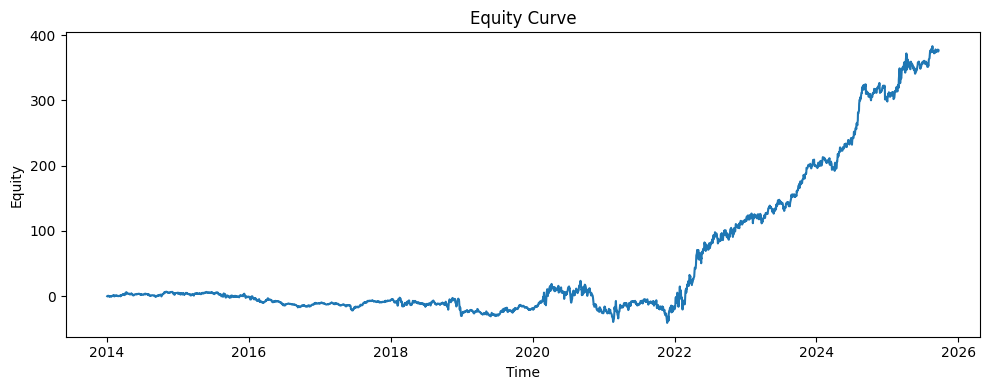

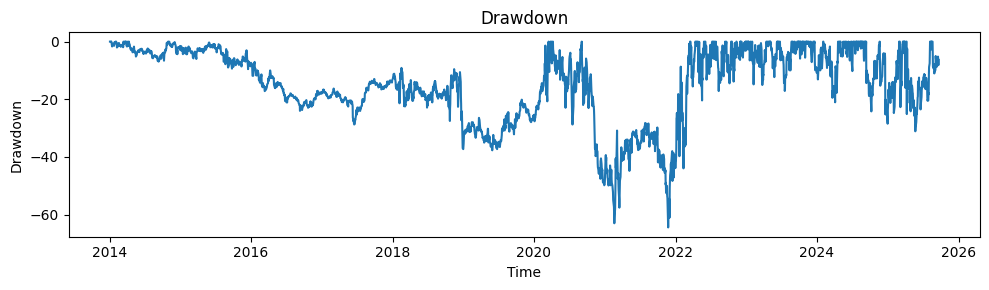


--- Histogram of Winning Trades (10 Buckets) ---
Bucket 1: 0.01 – 1.33 | Count=942, %=60.50
Bucket 2: 1.33 – 2.66 | Count=319, %=20.49
Bucket 3: 2.66 – 3.98 | Count=148, %=9.51
Bucket 4: 3.98 – 5.30 | Count=77, %=4.95
Bucket 5: 5.30 – 6.62 | Count=28, %=1.80
Bucket 6: 6.62 – 7.95 | Count=18, %=1.16
Bucket 7: 7.95 – 9.27 | Count=13, %=0.83
Bucket 8: 9.27 – 10.59 | Count=5, %=0.32
Bucket 9: 10.59 – 11.91 | Count=4, %=0.26
Bucket 10: 11.91 – 13.24 | Count=3, %=0.19


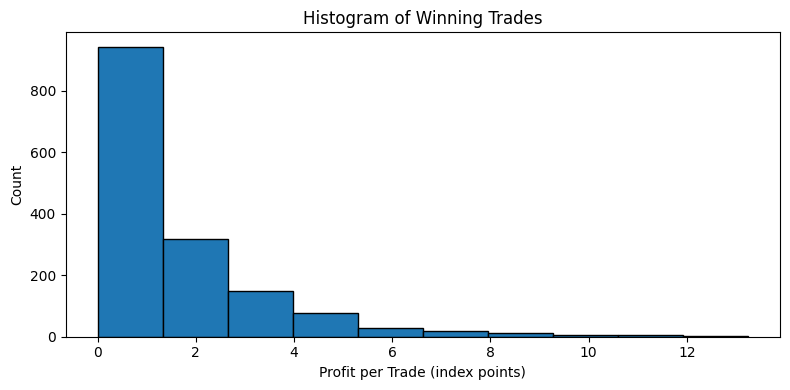


Trades and equity curve exported: trades_single_run_qqqh1.csv, equity_single_run_qqqh1.csv


In [3]:
# --- Block 3: Single run + reporting + plots ---

import matplotlib.pyplot as plt
import numpy as np

# ---- Parameters ----
TRADE_MODE    = "both"   # "buy" | "sell" | "both"
SMA_PERIOD    = 0        # 0 disables filter
PROFIT_TARGET = 2.6      # % of entry price (e.g., 1.0 = 1% profit target)

# ---- Run strategy ----
trades_df, summary, equity = run_strategy(
    df,
    trade_mode=TRADE_MODE,
    sma_period=SMA_PERIOD,
    profit_target=PROFIT_TARGET
)

# ---- Detailed log ----
if trades_df.empty:
    print("No trades taken with current parameters.")
else:
    print("\n--- Trades ---")
    print(trades_df[["side","date","entry_time","exit_time","entry","exit","pnl"]].to_string(index=False))

# ---- Consecutive streaks ----
def calc_streaks(pnls):
    max_wins = max_losses = 0
    cur_wins = cur_losses = 0
    for p in pnls:
        if p > 0:
            cur_wins += 1
            max_wins = max(max_wins, cur_wins)
            cur_losses = 0
        elif p < 0:
            cur_losses += 1
            max_losses = max(max_losses, cur_losses)
            cur_wins = 0
        else:
            cur_wins = cur_losses = 0
    return max_wins, max_losses

# Add streaks + win rates
for side in ["buy","sell","all"]:
    if side == "all":
        sdf = trades_df
    else:
        sdf = trades_df[trades_df["side"] == side]
    if not sdf.empty:
        max_wins, max_losses = calc_streaks(sdf["pnl"].tolist())
        wins = (sdf["pnl"] > 0).sum()
        total = len(sdf)
        win_rate = 100.0 * wins / total if total > 0 else 0.0
        summary[side]["max_consec_wins"] = max_wins
        summary[side]["max_consec_losses"] = max_losses
        summary[side]["win_rate_pct"] = win_rate
    else:
        summary[side]["max_consec_wins"] = 0
        summary[side]["max_consec_losses"] = 0
        summary[side]["win_rate_pct"] = 0.0

# ---- Summary ----
def fmt_stats(name, s):
    print(f"\n[{name.upper()}]")
    for k,v in s.items():
        if isinstance(v,float):
            print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

print("\n=== SUMMARY ===")
print(f"Total trades: {summary['total_trades']}")
fmt_stats("buy", summary["buy"])
fmt_stats("sell", summary["sell"])
fmt_stats("all", summary["all"])
print(f"\nMax Drawdown: {summary['max_drawdown']:.2f}")

# ---- Plots ----
if not equity.empty:
    plt.figure(figsize=(10,4))
    plt.plot(equity["time"], equity["equity"])
    plt.title("Equity Curve")
    plt.xlabel("Time"); plt.ylabel("Equity")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(equity["time"], equity["drawdown"])
    plt.title("Drawdown")
    plt.xlabel("Time"); plt.ylabel("Drawdown")
    plt.tight_layout(); plt.show()

# ---- Histogram of winning trades ----
if not trades_df.empty:
    winners = trades_df[trades_df["pnl"] > 0]["pnl"]
    if not winners.empty:
        counts, bins = np.histogram(winners, bins=10)
        total_wins = len(winners)
        percentages = counts / total_wins * 100

        print("\n--- Histogram of Winning Trades (10 Buckets) ---")
        for i in range(len(counts)):
            print(f"Bucket {i+1}: {bins[i]:.2f} – {bins[i+1]:.2f} | "
                  f"Count={counts[i]}, "
                  f"%={percentages[i]:.2f}")

        plt.figure(figsize=(8,4))
        plt.hist(winners, bins=10, edgecolor="black")
        plt.title("Histogram of Winning Trades")
        plt.xlabel("Profit per Trade (index points)")
        plt.ylabel("Count")
        plt.tight_layout(); plt.show()
    else:
        print("\nNo winning trades to plot histogram.")

# ---- Export results with datafile name ----
datafile_tag = csv_path.stem  # e.g. "qqqh1"
if not trades_df.empty:
    trades_file = f"trades_single_run_{datafile_tag}.csv"
    equity_file = f"equity_single_run_{datafile_tag}.csv"
    trades_df.to_csv(trades_file, index=False)
    equity.to_csv(equity_file, index=False)
    print(f"\nTrades and equity curve exported: {trades_file}, {equity_file}")


In [4]:
# --- Block 4: Optimizer with progress printing ---

def max_drawdown_from_equity(eq_df: pd.DataFrame) -> float:
    if eq_df.empty: return 0.0
    return float((eq_df["equity"] - eq_df["equity"].cummax()).min())

trade_modes = ["buy","sell","both"]
sma_periods = [0]
profit_targets = [0.0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6]

# Total runs
total_runs = len(trade_modes) * len(sma_periods) * len(profit_targets)
print(f"Starting optimizer: {total_runs} runs to evaluate...\n")

results = []
run_count = 0
for tm in trade_modes:
    for sp in sma_periods:
        for pt in profit_targets:
            run_count += 1
            tdf, summ, eq = run_strategy(df, trade_mode=tm, sma_period=sp, profit_target=pt)
            total_profit = summ["all"]["total_pnl"]
            max_dd = max_drawdown_from_equity(eq)
            dd_abs = abs(max_dd) if max_dd != 0 else 0.0
            ratio = (total_profit / dd_abs) if dd_abs > 0 else (
                np.inf if total_profit > 0 else -np.inf if total_profit < 0 else 0.0
            )

            row = {
                "trade_mode": tm,
                "sma_period": sp,
                "profit_target": pt,
                "trades": summ["total_trades"],
                "profit": round(total_profit,2),
                "max_drawdown": round(max_dd,2),
                "profit/abs(maxDD)": round(ratio,4)
            }
            results.append(row)

            # Show progress after each run
            print(f"Run {run_count}/{total_runs}: "
                  f"mode={tm}, sma={sp}, pt={pt} "
                  f"-> Profit={row['profit']}, MaxDD={row['max_drawdown']}, "
                  f"Ratio={row['profit/abs(maxDD)']}")

# Final sorted table
opt_df = pd.DataFrame(results).sort_values(
    ["profit/abs(maxDD)","profit"], ascending=[False,False]
).reset_index(drop=True)

print("\n=== Optimizer Results (sorted) ===")
pd.set_option('display.max_rows', 10000)
print(opt_df.to_string(index=False))

# --- Export optimizer results with datafile name ---
opt_file = f"optimizer_results_{datafile_tag}.csv"
opt_df.to_csv(opt_file, index=False)
print(f"\nOptimizer results exported: {opt_file}")



Starting optimizer: 42 runs to evaluate...

Run 1/42: mode=buy, sma=0, pt=0.0 -> Profit=222.71, MaxDD=-64.9, Ratio=3.4316
Run 2/42: mode=buy, sma=0, pt=0.2 -> Profit=57.24, MaxDD=-58.52, Ratio=0.9781
Run 3/42: mode=buy, sma=0, pt=0.4 -> Profit=63.24, MaxDD=-83.53, Ratio=0.757
Run 4/42: mode=buy, sma=0, pt=0.6 -> Profit=145.24, MaxDD=-52.44, Ratio=2.7696
Run 5/42: mode=buy, sma=0, pt=0.8 -> Profit=162.02, MaxDD=-44.16, Ratio=3.6691
Run 6/42: mode=buy, sma=0, pt=1 -> Profit=183.67, MaxDD=-53.22, Ratio=3.4511
Run 7/42: mode=buy, sma=0, pt=1.2 -> Profit=196.77, MaxDD=-47.11, Ratio=4.177
Run 8/42: mode=buy, sma=0, pt=1.4 -> Profit=207.86, MaxDD=-42.81, Ratio=4.8558
Run 9/42: mode=buy, sma=0, pt=1.6 -> Profit=201.83, MaxDD=-46.86, Ratio=4.3076
Run 10/42: mode=buy, sma=0, pt=1.8 -> Profit=201.23, MaxDD=-49.52, Ratio=4.0635
Run 11/42: mode=buy, sma=0, pt=2 -> Profit=200.48, MaxDD=-48.41, Ratio=4.1417
Run 12/42: mode=buy, sma=0, pt=2.2 -> Profit=204.97, MaxDD=-48.38, Ratio=4.2365
Run 13/42: mod